The idea is that if we minkowski reduce any given basis to its canonical form then we can find out which set of constraints it's HNF will obey because we will be able to identify its point group in the lattice basis.

If this is true then two cells that define the same grid should also have the same symmetry preserving HNFs as well.

First we'll check that the canonical form will actually give us the point group representation we want then we'll check that the HNFs are correct.

We will perform these checks for two different sets of lattice vectors that both define the same simple cubic lattice.

In [1]:
from phenum.symmetry import _get_lattice_pointGroup
import numpy as np
from phenum.vector_utils import _minkowski_reduce_basis

In [2]:
def forms_group(gens,pg):
    """Tests if the given generators forms a group.
    
    Args:
        gens (list of list): The generators to check.
        pg (list of list): The group the generators form.
        
    Returns:
        corret_gens (bool): True if the generators form the group.
    """
    
    correct_gens = False
    
    group = []
    for i in gens:
        for j in gens:
            test = np.matmul(i,j)
            in_group = False
            for k in group:
                if np.allclose(test,k):
                    in_group = True

            if not in_group:
                group.append(test)
    
    growing = True
    while growing:
        nfound = 0
        for i in gens:
            for j in group:
                test = np.matmul(i,j)
                in_group = False
                for k in group:
                    if np.allclose(test,k):
                        in_group = True
                if not in_group:
                    group.append(test)
                    nfound += 1
                    
        if nfound == 0:
            growing = False

    if not len(pg) == len(group):
        correct_gens = False
        
    else:
        for i in pg:
            in_group = False
            for k in group:
                if np.allclose(i,k):
                    correct_gens = True
                    break
            if correct_gens == False:
                break

    return correct_gens

def find_gens_of_pg(pg):
    """This subroutine finds the generators of the point group.
    
    Args:
        pg (list of list): A list of the matrix form of the point group.
        
    Returns:
        gens (list of list): Those operations that will generate the 
            remainder of the group.
    """
    
    from itertools import combinations
    
    n_gens = 1
    found_gens = False
    while not found_gens:
        possible_gens = list(combinations(range(len(pg)),r=n_gens))
        for test in possible_gens:
            test_gens = []
            for i in test:
                test_gens.append(pg[i])            
            if forms_group(test_gens,pg):
                gens = test_gens
                found_gens = True
                break
        n_gens += 1

    return gens

def same_symm(A,B,gens):
    """Determines if the supercell has the 
    same symmetry as the parent cell.
    
    Args:
        A (numpy.array): The parent cell vectors.
        B (numpy.array): The supercell vectors.
        gens (numpy.array): The generators of the point group.
        
    Returns:
        same (bool): True if B has symmetry of A.
    """
    
    same = True
    for g in gens:
        #print('R',g)
        BR = np.dot(B,g)
        test = np.dot(np.linalg.inv(B),np.dot(g,B))
        test2 = [[int(round(i)) for i in v] for v in test]
        #print('1',test)
        #print('2',test2)
        if not np.allclose(test,test2):
            same = False
            break
            
    return same

def find_HNFs(A,n):
    """Finds all the possible HNFs.
    
    Args:
        A (numpy.array): The lattice vectors for the parent cell.
        n (int): The number of cells.
        
    Returns:
        srHNFs (list of list): The HNFs for the cell.
    """
    
    srHNFs = []
    
    pg = _get_lattice_pointGroup(A)
    gens = find_gens_of_pg(pg)
    
    possibles = range(1,n+1)
    for a in possibles:
        keep = True
        if n%a == 0:
            rem = n/a
            for c in range(1,rem+1):
                if n%(c*a) == 0:
                    f = n/(c*a)
                    for b in range(c):
                        for d in range(f):
                            for e in range(f):
                                HNF = [[a,0,0],[b,c,0],[d,e,f]]
                                B = np.dot(A,HNF)
                                #print("H",HNF)
                                if same_symm(A,B,gens):
                                    srHNFs.append(HNF)
                
    return srHNFs   

We'll start by seeing what the point group generators look like in the two different basis vector representations.

In [121]:
A1 = [[1,0,0],[0,1,0],[0,0,1]]
A2 = [[1,1,0],[1,0,0],[0,0,1]]
pg1 = _get_lattice_pointGroup(A1)
gens1 = find_gens_of_pg(pg1)
pg2 = _get_lattice_pointGroup(A2)
gens2= find_gens_of_pg(pg2)

for i in range(2):
    print(i)
    print(np.dot(np.linalg.inv(A1),np.dot(gens1[i],A1)))
    print(np.dot(np.linalg.inv(A2),np.dot(gens2[i],A2)))


0
[[-1.  0.  0.]
 [ 0.  0. -1.]
 [ 0. -1.  0.]]
[[-1. -1.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
1
[[ 0. -1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]
[[-1.  0.  0.]
 [ 1.  0. -1.]
 [ 1.  1.  0.]]


As we can see the genertors have different forms when expressed in terms of the two independent basis.

Now we need to see what happens when we minkowski reduce both sets of basis vectors

In [122]:
mA1=_minkowski_reduce_basis(A1,1E-10)
mA2=_minkowski_reduce_basis(A2,1E-10)

In [123]:
mA1

[[0, 1, 0], [0, 0, 1], [1, 0, 0]]

In [124]:
mA2

[[1, 0, 0], [0, 1, 0], [0, 0, 1]]

Now both of our basis vectors have the same form and will have the same repsentation for their point group generators.

In [115]:
mpg = _get_lattice_pointGroup(mA1)
mgens = find_gens_of_pg(mpg)

for i in range(2):
    print(i)
    print(np.dot(np.linalg.inv(mA1),np.dot(mgens[i],mA1)))

0
[[ 0. -1.  0.]
 [-1.  0.  0.]
 [ 0.  0. -1.]]
1
[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [-1.  0.  0.]]


We can see that this is yet a third representation of our generators but we will accept this as the canonical form for the generators.

Now we need to determine if the canonical form and both of our initial lattices have the same symmetry preserving HNFs. We will do this through a brute force search for HNFs of size 2.

In [116]:
find_HNFs(A1,2)

[[[1, 0, 0], [0, 1, 0], [1, 1, 2]]]

In [117]:
find_HNFs(A2,2)

[[[1, 0, 0], [0, 1, 0], [1, 0, 2]]]

In [118]:
find_HNFs(mA1,2)

[[[1, 0, 0], [0, 1, 0], [1, 1, 2]]]

In [119]:
print(np.dot(A2,[[1, 0, 0], [0, 1, 0], [1, 0, 2]]))
print(np.dot(mA1,[[1, 0, 0], [0, 1, 0], [1, 1, 2]]))

[[1 1 0]
 [0 1 0]
 [1 0 2]]
[[0 1 0]
 [1 1 2]
 [1 0 0]]


It appears as though the two different lattices do not have the same symmetry preserving HNFs. We will confirm this by verifying that Binv.P.B is not integer for the case of lattice 2 when the symmetry preserving HNF of lattice 1 is in use.

In [11]:
B = np.dot(A2,[[1,0,0],[0,1,0],[1,1,2]])
for p in gens2:
    print(np.dot(np.linalg.inv(B),np.dot(p,B)))
    

[[ 1.   0.   0. ]
 [-1.  -1.   0. ]
 [-0.5  0.  -1. ]]
[[ 0.   0.   2. ]
 [-1.  -1.  -2. ]
 [ 0.5  1.   0. ]]


As we can see this results in non integer matrices. Therefore even though A1 and A2 define the same lattice they do not have the same symmetry preserving HNFs so we cannot use the canonical form of the lattices to try and group them.

In [12]:
T = np.dot(mA2,A2)
T

array([[0, 1, 0],
       [0, 0, 1],
       [1, 1, 0]])

In [13]:
mB = np.dot(mA2,[[1,0,0],[0,1,0],[1,1,2]])

In [14]:
B = np.dot(np.linalg.inv(T),mB)

In [15]:
B

array([[ 1., -1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  2.]])

In [16]:
mB

array([[0, 1, 0],
       [1, 1, 2],
       [1, 0, 0]])

In [17]:
for g in gens2:
    print(np.dot(np.linalg.inv(B),np.dot(g,B)))

[[-1.   0.   0. ]
 [-1.   1.   0. ]
 [ 0.5 -1.  -1. ]]
[[-2.   0.  -2. ]
 [-1.  -1.  -2. ]
 [ 1.5  1.   2. ]]


In [18]:
mB2= _minkowski_reduce_basis([[1,0,0],[0,1,1],[1,0,1]],1E-10)
pgt = _get_lattice_pointGroup(mB2)
gnst = find_gens_of_pg(pgt)

In [19]:
for i in range(2):
    print(i)
    print(np.dot(np.linalg.inv(mB2),np.dot(gnst[i],mB2)))

0
[[-1.  0.  0.]
 [ 0.  0. -1.]
 [ 0. -1.  0.]]
1
[[ 0. -1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]


In [126]:
Ac = [[1,0,0],[0,1,0],[0,0,1]]
A1 = [[1,1,0],[0,1,0],[0,0,1]]
#pgc = _get_lattice_pointGroup(Ac)
#genc = find_gens_of_pg(pgc)
H = find_HNFs(Ac,64)

In [127]:
H

[[[4, 0, 0], [0, 4, 0], [0, 0, 4]]]

In [128]:
T = np.dot(Ac,np.linalg.inv(A1))
T

array([[ 1., -1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [129]:
Bc = np.dot(Ac,H[0])
B1 = np.dot(np.linalg.inv(T),Bc)

In [130]:
B1

array([[ 4.,  4.,  0.],
       [ 0.,  4.,  0.],
       [ 0.,  0.,  4.]])

In [131]:
H1=np.dot(np.linalg.inv(A1),B1)
H1

array([[ 4.,  0.,  0.],
       [ 0.,  4.,  0.],
       [ 0.,  0.,  4.]])

In [132]:
pg1 = _get_lattice_pointGroup(A1)
gen1 = find_gens_of_pg(pg1)
for p in gen1:
    print(np.dot(np.linalg.inv(B1),np.dot(p,B1)))


[[ 1.  0.  0.]
 [-1. -1.  0.]
 [ 0.  0. -1.]]
[[-1. -1.  1.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]


# We need to be able to define the dual in order to make the grids.

In [133]:
def find_mat_dual(A):
    """Finds the dual of the matrix A.
    
    Args:
        A (numpy.array): The input matrix where the columns are the 
            vectors.
        
    Returns:
        dualA (numpy.array): The dual of the matrix A.
    """
    
    dualA = np.transpose(np.linalg.inv(A))
    return(dualA)    

## Plots to see if we're doing it right

In [192]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from sampling import make_mesh
def show_grid(lattice,grid):
    """Plots the shape of each HNF.

    Args:
        lattice (numpy.array): The parent cell.
        grid (numpy.array): The grid vectors for the k-points.
    """
    #from phenum.grouptheory import SmithNormalForm
    #from phenum.vector_utils import map_enumStr_to_real_space, cartesian2direct
    #from operator import mul
    from numpy import array, mgrid, dot, matmul
    #from itertools import product

    #try:
    #    from functools import reduce
    #except ImportError:
    import numpy as np

    grid = grid/(2**(1/3))
    ## This part just plots the parent cell.
    #aBas = array([[0,0,0]])
        
    #(SNF,L,R) = SmithNormalForm(HNF)
    #diag = [SNF[0][0],SNF[1][1],SNF[2][2]]
    #vol = reduce(mul,diag,1)
    #sLV = matmul(lattice,HNF).tolist()
    sLV = lattice
    
    # the corners of the polyhedron except the origin.
    x = np.array(sLV[0])
    y = sLV[1]#x-np.array(sLV[1])
    z = sLV[2]
    xy = (array(x)+array(y)).tolist()
    xz = (array(x)+array(z)).tolist()
    yz = (array(y)+array(z)).tolist()
    xyz = (array(y)+array(x)+array(z)).tolist()

    correct = [[0,0,0],x,y,z,xy,xz,yz,xyz]
    xf = [i[0] for i in correct]
    yf = [i[1] for i in correct]
    zf = [i[2] for i in correct]

    # we need to put the shifted atoms back into cartesian corrdinates.
    #atoms = []
    #for atom in aBas:
    #    atoms.append(dot(atom,sLV).tolist())
                        
    #    xa = [atom[0] for atom in atoms]
    #    ya = [atom[1] for atom in atoms]
    #    za = [atom[2] for atom in atoms]

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_aspect('equal')
    ax.set_axis_off()
     #   ax.scatter(xa,ya,za,zdir='z',c='red',s=1000)
        # ax.scatter(xf,yf,zf,zdir='z',c='red')

    ax.plot([0,x[0]],[0,x[1]],[0,x[2]],'k')
    ax.plot([0,y[0]],[0,y[1]],[0,y[2]],'k')
    ax.plot([0,z[0]],[0,z[1]],[0,z[2]],'k')
    ax.plot([xz[0],x[0]],[xz[1],x[1]],[xz[2],x[2]],'k')
    ax.plot([xz[0],z[0]],[xz[1],z[1]],[xz[2],z[2]],'k')
    ax.plot([xy[0],x[0]],[xy[1],x[1]],[xy[2],x[2]],'k')
    ax.plot([xy[0],y[0]],[xy[1],y[1]],[xy[2],y[2]],'k')
    ax.plot([xz[0],z[0]],[xz[1],z[1]],[xz[2],z[2]],'k')
    ax.plot([yz[0],z[0]],[yz[1],z[1]],[yz[2],z[2]],'k')
    ax.plot([yz[0],y[0]],[yz[1],y[1]],[yz[2],y[2]],'k')
    ax.plot([yz[0],xyz[0]],[yz[1],xyz[1]],[yz[2],xyz[2]],'k')
    ax.plot([xz[0],xyz[0]],[xz[1],xyz[1]],[xz[2],xyz[2]],'k')
    ax.plot([xy[0],xyz[0]],[xy[1],xyz[1]],[xy[2],xyz[2]],'k')

    max_range = array([array(xf).max()-array(xf).min(),array(yf).max()-array(yf).min(),
                        array(zf).max()-array(zf).min()]).max()
    Xb = 0.5*max_range*mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(array(xf).max()+array(xf).min())
    Yb = 0.5*max_range*mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(array(yf).max()+array(yf).min())
    Zb = 0.5*max_range*mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(array(zf).max()+array(zf).min())

    for xb, yb, zb in zip(Xb,Yb,Zb):
        ax.plot([xb],[yb],[zb],'w')

        
    ## Now we need to plot the grid points
    points = make_mesh(lattice,grid,[0,0,0])
    for p in points:
        ax.scatter(p[0],p[1],p[2],zdir='z',c='r')
        #fig.savefig("HNF.pdf")
        #if show: #pragma: no cover
    plt.show()
        #else:
        #    plt.close()

<IPython.core.display.Javascript object>


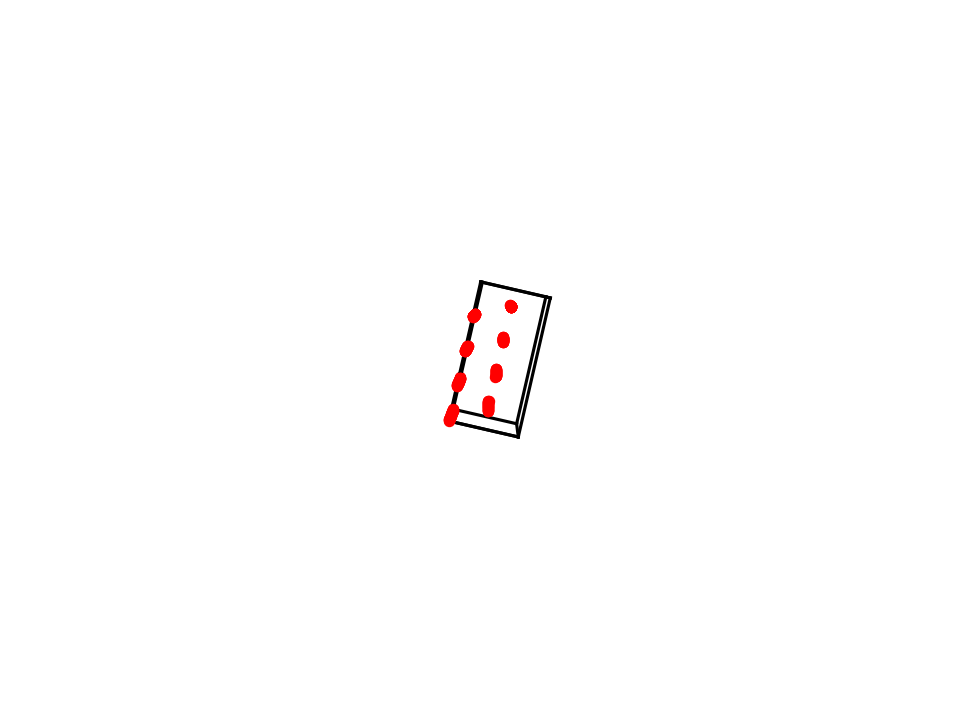

In [193]:
show_grid(A1,find_mat_dual(Bc))

# Determination of oreintation of grid

In order to make use of the canonical form we need to know if there is a way to find the rotation between the lattices that are x-y to those that are x-z and so on. This is neccassary because we need to be able to rotate the grid into the correct orientation as well.

For testing and demonstrative purposes we'll be playing with a tetragonal grid.

In [277]:
A1 = [[1,0,0],[0,2,0],[0,0,4]]
A2 = [[2,0,0],[0,1,0],[0,0,4]]
A3 = [[4,0,0],[0,2,0],[0,0,1]]
A4 = [[1,0,0],[0,4,0],[0,0,2]]
mA1 = _minkowski_reduce_basis(A1,1E-10)
mA2 = _minkowski_reduce_basis(A2,1E-10)
mA3 = _minkowski_reduce_basis(A3,1E-10)
mA4 = _minkowski_reduce_basis(A4,1E-10)

In [278]:
print(mA1)
print(mA2)
print(mA3)
print(mA4)

[[1, 0, 0], [0, 2, 0], [0, 0, 4]]
[[0, 1, 0], [0, 0, 4], [2, 0, 0]]
[[0, 0, 1], [4, 0, 0], [0, 2, 0]]
[[1, 0, 0], [0, 4, 0], [0, 0, 2]]


In [281]:
pg1 = _get_lattice_pointGroup(mA1)
g1 = find_gens_of_pg(pg1)
pg2 = _get_lattice_pointGroup(mA2)
g2 = find_gens_of_pg(pg2)
pg3 = _get_lattice_pointGroup(mA3)
g3 = find_gens_of_pg(pg3)
pg4 = _get_lattice_pointGroup(mA4)
g4 = find_gens_of_pg(pg4)

In [282]:
for i in range(len(g1)):
    print(i)
    print(np.dot(np.linalg.inv(A1),np.dot(g1[i],A1)))
    print(np.dot(np.linalg.inv(A2),np.dot(g2[i],A2)))
    print(np.dot(np.linalg.inv(A3),np.dot(g3[i],A3)))
    print(np.dot(np.linalg.inv(A4),np.dot(g4[i],A4)))

0
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
1
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
2
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]


Here we can see that the orientation of the crystal impacts the representation (and possibly order) of the generators. 

For the rest of these tests we shall call mA1 the canonical basis we want to identify mA2, mA3, and mA4 as.

We will begin by attempting to 'rotate' the representanions of the generators.

In [169]:
z90=[[0,-1,0],[1,0,0],[0,0,1]]
x90 = [[1,0,0],[0,0,-1],[0,1,0]]
y90 = [[0,0,-1],[0,1,0],[1,0,0]]

In [158]:
cg = []
for g in g1:
    cg.append(np.dot(np.linalg.inv(mA1),np.dot(g,mA1)))

In [164]:
mt = np.dot(z90,mA2)
pgt = _get_lattice_pointGroup(mt)
gt = find_gens_of_pg(pgt)
same = True

for i in range(len(gt)):
    tt = np.dot(np.linalg.inv(mt),np.dot(gt[i],mt))
    this_time = False
    for g in cg:
        if np.all(tt == g):
            this_time = True
            break
    if this_time == False:
        same = False
        break
print(same)

True


In [172]:
mt = np.dot(y90,mA2)
pgt = _get_lattice_pointGroup(mt)
gt = find_gens_of_pg(pgt)
same = True

for i in range(len(gt)):
    tt = np.dot(np.linalg.inv(mt),np.dot(gt[i],mt))
    this_time = False
    for g in cg:
        if np.all(tt == g):
            this_time = True
            break
    if this_time == False:
        same = False
        break
print(same)

True


In [176]:
mt = np.dot(x90,mA3)
pgt = _get_lattice_pointGroup(mt)
gt = find_gens_of_pg(pgt)
same = True

for i in range(len(gt)):
    tt = np.dot(np.linalg.inv(mt),np.dot(gt[i],mt))
    this_time = False
    for g in cg:
        if np.all(tt == g):
            this_time = True
            break
    if this_time == False:
        same = False
        break
print(same)

True


In [180]:
mt = mA4#np.dot(z90,mA4)
pgt = _get_lattice_pointGroup(mt)
gt = find_gens_of_pg(pgt)
same = True

for i in range(len(gt)):
    tt = np.dot(np.linalg.inv(mt),np.dot(gt[i],mt))
    this_time = False
    for g in cg:
        if np.all(tt == g):
            this_time = True
            break
    if this_time == False:
        same = False
        break
print(same)

True


In [185]:
H = find_HNFs(mA1,4)
Ht = H[3]
Ht

[[1, 0, 0], [0, 1, 0], [2, 2, 4]]

In [186]:
Bc = np.dot(mA1,Ht)

<IPython.core.display.Javascript object>


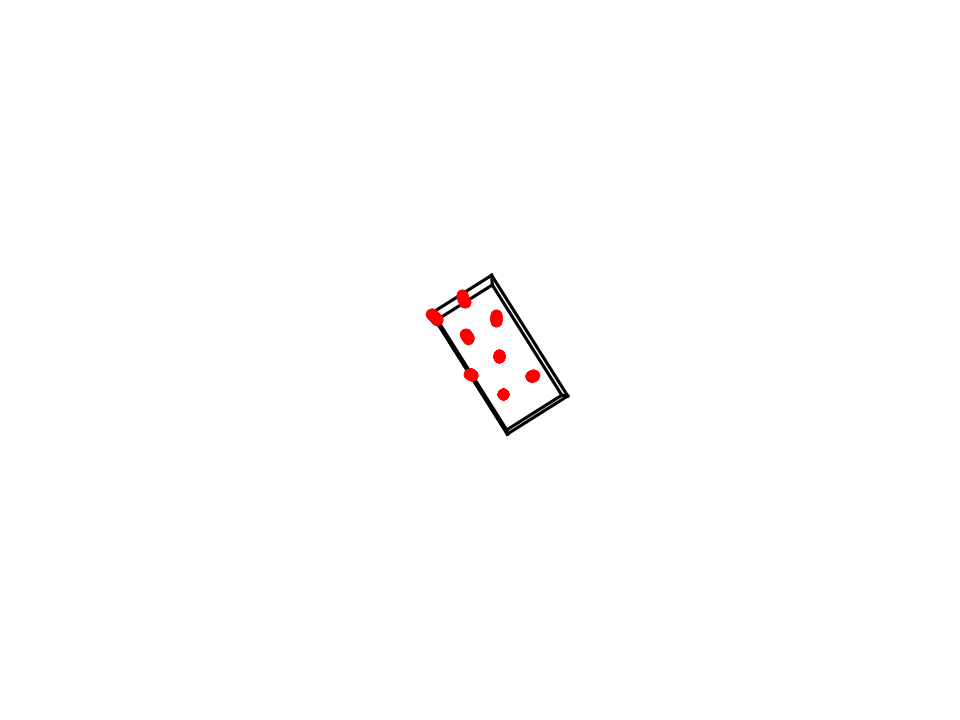

In [194]:
show_grid(A2,find_mat_dual(Bc))

# Try transformation in other order Ac = Au T

In [239]:
Au = [[1,1,0],[0,1,0],[0,0,1]]
Ac = _minkowski_reduce_basis(Au,1E-10)
T = np.dot(np.linalg.inv(Au),Ac)

In [240]:
H = find_HNFs(Ac,2)

In [241]:
Bc = np.dot(Ac,H[0])

In [242]:
Bc

array([[0, 1, 0],
       [1, 1, 2],
       [1, 0, 0]])

In [243]:
Bu = np.dot(Bc,np.linalg.inv(T))

In [244]:
Bu

array([[ 1.,  1.,  0.],
       [ 1.,  3.,  1.],
       [ 0.,  0.,  1.]])

In [245]:
pg1 = _get_lattice_pointGroup(Au)
g1 = find_gens_of_pg(pg1)

In [246]:
for i in range(len(g1)):
    print(np.dot(np.linalg.inv(Bu),np.dot(g1[i],Bu)))

[[-1. -4. -2.]
 [ 0.  1.  1.]
 [ 0.  0. -1.]]
[[-1.  0.  1.]
 [ 0. -1. -1.]
 [ 1.  3.  1.]]


In [247]:
Hu = np.dot(np.linalg.inv(Au),Bu)

In [248]:
from sampling import LowerHermiteNormalForm
Hu, U = LowerHermiteNormalForm(Hu)
Hu

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  2.]])

In [249]:
find_HNFs(Au,2)

[[[1, 0, 0], [0, 1, 0], [1, 0, 2]]]

In [256]:
R1 = [[1,0,0],[0,2,0],[0,0,4]]
R2 = [[1,0,0],[0,4,0],[0,0,2]]

In [257]:
RT = np.dot(R1,np.linalg.inv(R2))
RT

array([[ 1. ,  0. ,  0. ],
       [ 0. ,  0.5,  0. ],
       [ 0. ,  0. ,  2. ]])

In [258]:
np.linalg.det(RT)

1.0

In [262]:
from math import cos, sin
def rot_mat(th):
    R = [[cos(th),-sin(th),0],[sin(th),cos(th),0],[0,0,1]]
    return R

In [274]:
R = rot_mat(np.pi/3)
Rt = np.dot(R1,R)
pg1 = _get_lattice_pointGroup(R1)
g1 = find_gens_of_pg(pg1)
pgt = _get_lattice_pointGroup(Rt)
gt = find_gens_of_pg(pgt)

In [276]:
for i in range(len(g1)):
    print(i)
    print(np.dot(np.linalg.inv(R1),np.dot(g1[i],R1)))
    print(gt[i])
    print(np.dot(np.linalg.inv(Rt),np.dot(gt[i],Rt)))    

0
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
[[-1.0, 0.0, 0.0], [-5.551115123125783e-17, -0.9999999999999999, 0.0], [0.0, 0.0, -1.0]]
[[ -1.00000000e+00   1.11022302e-16   0.00000000e+00]
 [  0.00000000e+00  -1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -1.00000000e+00]]
1
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
[[-1.0, 0.0, 0.0], [-5.551115123125783e-17, -0.9999999999999999, 0.0], [0.0, 0.0, 1.0]]
[[ -1.00000000e+00   1.11022302e-16   0.00000000e+00]
 [  0.00000000e+00  -1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
2
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
[[0.4999999999999998, 0.8660254037844388, 0.0], [0.8660254037844388, -0.49999999999999967, 0.0], [0.0, 0.0, -1.0]]
[[ 0.6875     -0.32475953  0.        ]
 [-1.62379763 -0.6875      0.        ]
 [ 0.          0.         -1.        ]]


# Character of group to ID which relations to use

In [288]:
sc = [[1,0,0],[0,1,0],[0,0,1]]
bcc = [[-0.5,0.5,0.5],[0.5,-0.5,0.5],[0.5,0.5,-0.5]]
fcc = [[0,0.5,0.5],[0.5,0,0.5],[0.5,0.5,0]]

In [292]:
def get_char_gen(lat):
    
    alat = _minkowski_reduce_basis(lat,1E-10)
    pg = _get_lattice_pointGroup(alat)
    gens = find_gens_of_pg(pg)
    
    ks = []
    for g in gens:
        ks.append(np.dot(np.linalg.inv(alat),np.dot(g,alat)))
    
    for k in ks:
        print(np.trace(k))
    

# Do Mueller Grids preserve Symmetry?

In [24]:
A = [[1,0,0],[-0.5,0.86602540,0],[0,0,3.26598640]]
gens = find_gens_of_pg(_get_lattice_pointGroup(A))
A = np.transpose(A)
Ar = np.transpose(np.linalg.inv(A))

In [29]:
grid = np.transpose(np.linalg.inv(np.dot(Ar,np.transpose(_minkowski_reduce_basis([[1,0,0],[0.25, 0.625, 0.0],[0,0,1]],1E-7)))))

In [30]:
for g in gens:
    print(np.dot(np.linalg.inv(grid),np.dot(g,grid)))

[[ -1.00000000e+00   0.00000000e+00   5.55111512e-17]
 [  0.00000000e+00  -1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -1.00000000e+00]]
[[ -1.00000000e+00   0.00000000e+00   5.55111512e-17]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -1.00000000e+00]]
[[ 0.8  0.  -0.6]
 [ 0.  -1.   0. ]
 [-0.6  0.  -0.8]]


In [31]:
grid2 = np.transpose(np.linalg.inv(np.dot(Ar,np.transpose(_minkowski_reduce_basis([[0.16666666666667, 0.91666666666667, 0.5],
                                                        [0.5, 0.75, 0.5],
                                                        [0.0, 0.125, 0.5]],1E-7)))))

In [32]:
for g in gens:
    print(np.dot(np.linalg.inv(grid2),np.dot(g,grid2)))

[[ -1.00000000e+00   0.00000000e+00  -7.88860905e-31]
 [ -5.55111512e-17  -1.00000000e+00   0.00000000e+00]
 [ -2.22044605e-16   0.00000000e+00  -1.00000000e+00]]
[[ -1.00000000e+00   0.00000000e+00  -7.88860905e-31]
 [ -4.28571429e-01   1.00000000e+00  -2.85714286e-01]
 [ -2.22044605e-16   0.00000000e+00  -1.00000000e+00]]
[[ -1.00000000e+00   0.00000000e+00   1.12630671e-14]
 [  4.28571429e-01  -1.00000000e+00   2.85714286e-01]
 [  3.00000000e+00   0.00000000e+00   1.00000000e+00]]


## Froyen HCP

In [33]:
grid = np.transpose(np.linalg.inv(np.dot(Ar,np.transpose(_minkowski_reduce_basis([[0.25,-0.25,0],[0, 0.25, 0.0],[0,0,1]],1E-7)))))

In [34]:
for g in gens:
    print(np.dot(np.linalg.inv(grid),np.dot(g,grid)))

[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 1.  0. -1.]]


In [35]:
grid2 = np.transpose(np.linalg.inv(np.dot(Ar,np.transpose(_minkowski_reduce_basis([[0.125, -0.125, 0],
                                                        [0., 0.125, 0.],
                                                        [0.0, 0., 0.5]],1E-7)))))

In [36]:
for g in gens:
    print(np.dot(np.linalg.inv(grid2),np.dot(g,grid2)))

[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 1.  0. -1.]]


## Cu, a cubic test

In [37]:
A = [[-.5,.5,.5],[0.5,-.5,.5],[.5,.5,-.5]]
gens = find_gens_of_pg(_get_lattice_pointGroup(A))
A = np.transpose(A)
Ar = np.transpose(np.linalg.inv(A))

In [38]:
grid = np.transpose(np.linalg.inv(np.dot(Ar,np.transpose(_minkowski_reduce_basis([[0.33333333333333, 0.00000000000000, 0.33333333333333],
                               [0.66666666666667, 0.66666666666667, 0.33333333333333],
                               [0.66666666666667, 0.33333333333333, 0.66666666666667]],1E-10)))))

In [39]:
for g in gens:
    print(np.dot(np.linalg.inv(grid),np.dot(g,grid)))

[[ -1.00000000e+00   1.00000000e+00   3.01425551e-14]
 [ -1.00000000e+00   5.98595247e-14   1.00000000e+00]
 [ -1.00000000e+00   5.99520433e-14  -2.98649994e-14]]
[[ -6.02851102e-14  -1.00000000e+00   0.00000000e+00]
 [ -1.00000000e+00   6.02110954e-14  -1.11022302e-16]
 [  8.95949981e-14  -8.95949981e-14  -1.00000000e+00]]


In [40]:
grid2= np.transpose(np.linalg.inv(np.dot(Ar,np.transpose(_minkowski_reduce_basis([[0.16666666666667, 0.00000000000000, 0.16666666666667],
                               [0.33333333333333, 0.83333333333333, 0.16666666666667],
                               [0.50000000000000, 0.16666666666667, 0.50000000000000]],1E-10)))))

In [41]:
for g in gens:
    print(np.dot(np.linalg.inv(grid2),np.dot(g,grid2)))

[[ -1.00000000e+00   1.19793064e-13  -1.00000000e+00]
 [ -1.00000000e+00   2.39808173e-13   1.79227004e-13]
 [  1.00000000e+00  -1.00000000e+00  -2.40307774e-13]]
[[  1.79134485e-13  -1.79578574e-13   1.00000000e+00]
 [ -4.19220214e-13  -1.00000000e+00  -4.19146199e-13]
 [  1.00000000e+00  -1.79578574e-13  -1.79134485e-13]]
